# INTELLIGENT INVESTMENT CONSULTANT FOR LENDING CLUB</p>
### Author: Yong Zhao

## TABLE OF CONTENTS

1. [Introduction](#INTRODUCTION)
2. [Project Summary](#PROJECT-SUMMARY)
3. [Data Acquisition](#Data-Acquisition)
4. [Exploratory Analysis](#Exploratory-Analysis)
 - [Feature Exploration](#Feature-Exploration)
 - [Data Exploration](#Data-Exploration)
 - [Exploratory Visualization](#Exploratory-Visualization)
5. [Feature Engineering](#Feature-Engineering)
 - [Categorical Feature Treatment](#Categorical-Feature-Treatment)
 - [Feature Responses Visualization](#Feature-Responses-Visualization)
6. [XGBoost Model Buidling](#XGBoost-Model-Building)
 - [Train/Test Splitting](#Train/Test-Splitting)
 - [Parameter Auto-tuning](#Parameter-Auto-tuning)
 - [Find Best Parameters](#Find-Best-Parameters)
7. [Model Integration](#Model-Integration)
8. [Model Evaluation](#Model-Evaluation)
 - [Feature Importance](#Feature-Importance)
 - [Testing Set Scores](#Testing-Set-Scores)
 - [Plot ROC-AUC](#Plot-ROC-AUC)
 - [Select Thresholds](#Select-Thresholds)
9. [CONCLUSION](#CONCLUSION)


# INTRODUCTION

[[go back to the top]](#TABLE-OF-CONTENTS)

[Lending Club](https://www.lendingclub.com/) is a US peer-to-peer lending company that provides a largest peer-to-peer online lending platform. The Lending Club’s platform enables borrowers to obtain a loan funded by investors. Investors profit from interest payments on loans. Based on the levels of loans' default rate, Lending categorizes the quality of the loans into seven grades, each of which assigned with different interest rates and risks. From the investors' point of view, they want to find out the potential default rate of each specific loans, in order to avoid investing on those loans with high risk of default. **The goal of this project is to build a predictive model to predict the default rate of the newly issued loans, based on information from historic loans.** 

The centerpiece of this model’s operation is to use algorithm to choose which notes to invest in. Often investors have to choose between hundreds or thousands of available loans at Lending Club. This model makes the process easier by using machine-learning to calculate which notes are more likely to perform better than others. The moment new loans are added to the platforms, the algorithm analyzes the variables of these loans and only invests in the best ones.

# PROJECT SUMMARY

[[go back to the top]](#TABLE-OF-CONTENTS)

This project is implemented using Python on the Jupyter Notebook platform. Data processing and machine learning packages such as Pandas and Sci-kit Learn are utilized. The modeling is trained based on the Lending Club's historic loan data from year 2014.

The target is to predict the default rate of the new loans listed on Lending Club. The workflow of the project consists of 6 steps: 
* [Loading Data](#Data-Acquisition)
* [Exploratory Analysis](#Exploratory-Analysis)
* [Feature Engineering](#Feature-Enginering)
* [Model Building](#Model-Building)
* [Model Integration](#Model-Integration)
* [Model Evaluation](#Model-Evaluation)

Data cleaning are performed to uniform the features used in the training set and the target set. Categorical variables are extracted into meaningful features for model input via feature engineering. XGBoost (Extreme Gradient Boost) is used as the modeling algorithm. As a advanced Gradient Boosted Regression Trees (GBRT) algorithm,  XGBoost adopted several advantages of GBRT such as: natural handling of data of mixed type , predictive power, robustness to outliers in output space (via robust loss functions). Combining both Random Forest and Adaptive Gradent Boosting algorithms, XGBoost exhibited high efficiency and flexibility in modeling large datasets with ease of implementation. 

The model is then autotuned to optimize its performance using Bayesian Optimization and Cross Validation. The tuned model is tested using the Area Under Curve (AUC) of the Receiver Operating Characteristics (ROC) as the performance metrics. The overall AUC score reaches above 73% on the testing set. Finally, the tuned model is saved using Pickle and integrated into an interactive web-application built with Flask Framework.

The total runtime for model building and model tuning may take 4-5 hours, depending on computer hardware. 

## Required Libraries

This notebook uses several standard Python packages and special packages for model building and model tuning. The primary libraries that we'll be using are:

* **requests**: request data from API servers. 
* **pandas**: and **numpy**: numeric paneled data operation. 
* **matplotlib** and **seaborn**: data visualization.
* **xgboost**: XGBoost algorithm.
* **bayes_opt**: Bayesian Optimization.
* **sklearn**: Sci-kit Learn for model buidling and evaluation.


In [4]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
%matplotlib inline

# Data Acquisition

[[go back to the top]](#TABLE-OF-CONTENTS)

## Load Current Loan Data

Lending Club constantly updates its newly issued loans, which are accessed via Lending Club's API services. The data are loaded into Pandas DataFrame using Python's "requests" function. The current loan data are then saved into json format and read into Pandas DataFrame. 

In [5]:
api_key = open('apikey.txt', 'r').read()
headers = {"Authorization": api_key}
url = 'https://api.lendingclub.com/api/investor/v1/loans/listing'

In [6]:
r = requests.get(url, headers = headers)

In [9]:
data = r.json()

In [10]:
myData = data['loans']

In [11]:
with open('current_list.txt', 'w') as outfile:
    json.dump(myData, outfile)

In [12]:
df_current = pd.read_json('current_list.txt')

## Load 2014 Loan Data

Lending Club offers open access to its historical loan data from 2007. In this project the loan data from year 2014 were loaded into Pandas DataFrame to be used as the training set. 

In [ ]:
df_2014 = pd.read_csv('LoanStats3c_securev1.csv', skiprows = 1, skipfooter=2)

# Exploratory Analysis

[[go back to the top]](#TABLE-OF-CONTENTS)

Exploratory Analysis consist of parts:
* [Feature Exploration](#Feature-Exploration)
* [Data Exploration](#Data-Exploration)
* [Exploratory Visualization](#Exploratory-Visualization)

The target feature of the predictive model is labeled as "loan status", which refers to the stutus of loans as of today. A histogram is plotted to visualize the counts of different statuses. There are totally 7 different loan statuses, among which "Fully Paid" and "Charged Off" refer to those loans whose statuses are already determined, while all other statuses may still change over time. In this project only the loans with statuses of "Fully Paid" and "Charged Off" are considered. They are labeled as "0" (no default) and "1" (default), respectively. 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

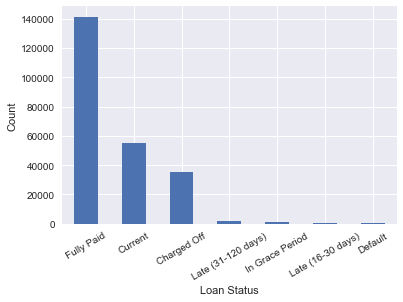

In [21]:
g = df_2014.loan_status.value_counts().plot('bar', rot = 90)
g.set_xlabel('Loan Status')
g.set_ylabel('Count')
plt.xticks(rotation = 30)

From the above histogram, it is seen that the ratio between "Fully Paid" and "Charged Off" loans are about 4:1. Discarding all other loan statuses, the overall default rate for the 2014 loans is about 0.2. Over time, this ratio may change slightly but this does not influence the training results much.

The term of the loans has only two values, 36 months or 60 months, in the ratio of about 2:1. As of the date of this project, most of the 36 months loans should be closed but most 60 months loans are still open. So this model will have a better prediction performance on the 36 months loans than the 60 months loans. 

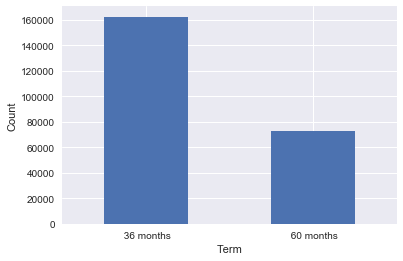

In [27]:
g = df_2014.term.value_counts().plot('bar', rot = 0)
g.set_xlabel('Term')
g.set_ylabel('Count')

## Feature Exploration

In [38]:
df_2014.shape, df_current.shape

((235629, 143), (16, 103))

Comparing the features between the historic and the current data, there are several distinct differences: First, the number of features in the 2014 data is more than the current data. Second, the feature names are labeled differently: the historic feature names are separated by underscore "\_", while the current feature names have upper case letters. To uniform the feature names, the underscores are deleted in the historic data, and the letters are all converted to lower cases in the current data. In some cases, different feature names may refer to the same variable, so those feature names are uniformed also. 

In [41]:
cols = []
for col in df_2014.columns:
    cols.append(col.replace("_", ""))

In [42]:
df_2014.columns = cols

In [43]:
cols = []
for col in df_current.columns:
    cols.append(col.lower())

In [44]:
df_current.columns = cols

In [45]:
# Change some column names in df_2014 to match df_current
# Fundedamnt to fundedamount. But this feature is not used since all loans in history data are fully funded. 
df_2014.rename(columns={'zipcode': 'addrzip', 'verificationstatus': 'isincv', 'verificationstatusjoint': 'isincvjoint',\
                        'loanamnt': 'loanamount', 'numacctsever120pd': 'numacctsever120ppd'}, inplace=True)

Having uniformed the feature names, the next task is to find the common features in both historic and current data sets. The common features are extracted using set operations. The historic data frame df_2014 is then reduced to only have the common features plus the loan status ("loanstatus") and issued date ("issued"). 

In [48]:
#Find common columns
com_cols = set(df_2014.columns) & set(df_current.columns)
hist_unique = set(df_2014.columns) - set (df_current.columns)
cur_unique = set(df_current.columns) - set (df_2014.columns) 

In [49]:
df_2014 = df_2014[list(com_cols) + ["loanstatus", "issued"]]

## Data Exploration

The next step is the preliminary data exploration. There are many all-null columns, which are dropped from the training set. The rows with loan statuses other than "Charged Off" or "Fully Paid" are also dropped from the training set. The resulted data frame has three different data types: "object", "int64", and "float64". All the "object" features are saved into a list of categorical variables "cat_vars', and all the numeric features are saved into "num_vars". 

There are 18 resulted categorical features: 

'addrstate', 'addrzip', 'applicationtype', 'desc', 'earliestcrline',
'emplength', 'emptitle', 'grade', 'homeownership', 'initialliststatus',
'intrate', 'isincv', 'issued', 'loanstatus', 'purpose', 'revolutil',
'subgrade', 'term'    
       
Each of them will be converted or transformed in the [Feature Engineering](#Feature-Engineering) step to be processed by the model algorithm.  

In [52]:
null_2014 = df_2014.columns[df_2014.isnull().all()]

In [53]:
df_2014.drop(null_2014, axis = 1, inplace=True)

In [54]:
df_2014 = df_2014[df_2014.loanstatus.isin(["Charged Off", "Fully Paid"])]

In [55]:
df_2014_raw = df_2014

In [57]:
data_types = df_2014.dtypes  
cat_vars = list(data_types[data_types=='object'].index)
num_vars = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

In [58]:
print ("There are %d categorical features. We will process them one by one." %len(cat_vars))

There are 18 categorical features. We will process them one by one.


## Exploratory Visualization

Visualization packages "Matplotlib" and "Seaborn" were used to plot the distribution of the categorical features. 

In [60]:
print(len(cat_vars), len(num_vars), df_2014.shape)

18 58 (176552, 76)


In [61]:
cat_vars_plot = ['applicationtype', 'isincv', 'purpose', 'subgrade', 'initialliststatus', 'addrstate', 'grade', 'term',\
                'homeownership', 'emplength']

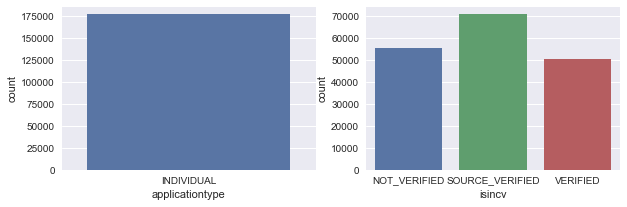

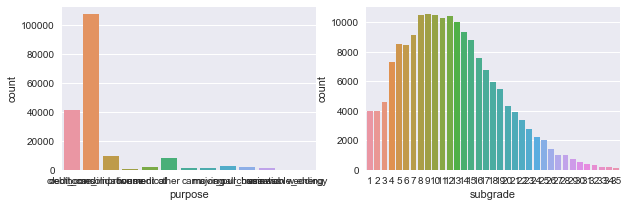

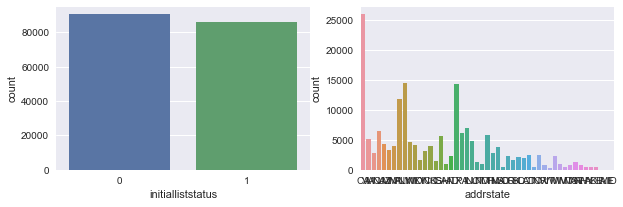

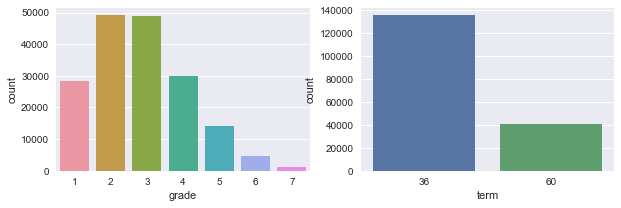

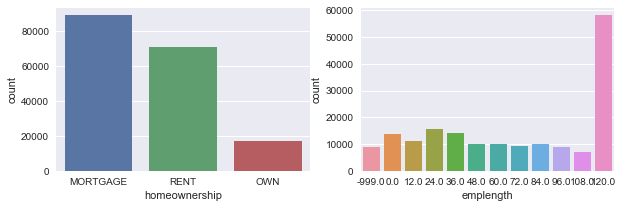

In [189]:
n_cols = 2
n_rows = 5
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(10, 3))
    for j in range(n_cols):
        g = sns.countplot(x=cat_vars_plot[i*n_cols+j], data=df_2014, ax=ax[j])
        g.set_xticklabels(labels=g.get_xticklabels(), rotation = 0)

# Feature Engineering

[[go back to the top]](#TABLE-OF-CONTENTS)

Feature engineering is conducted mainly on the categorical features. The purpose of feature engineering is either to convert categorical variables to numerical variables or extract new features that may potentially enhance model performance. There are 5 different types of categorical features, each is treated with different strategies. The table below lists each type of categorical features and their corresponding solutions.

|           Type          |        Name       |        Definition       |               Solution              |
|:-----------------------:|:-----------------:|:-----------------------:|:-----------------------------------:|
| Intrinsically numerical |      intrate      |      Interest rate      |         Convert to numerical        |
|                         |     revolutil     | Credit line utilization |                 ..                  |
|                         |        term       |   Term of loan (36/60)  |                 ..                  |
|        Date-time        |   earliestcrline  |  Date first credit line | Extract new feature: credit history |
|     High cardinality    |      emptitle     |     Employment title    |     NLP and extract new features    |
|                         |        desc       |      User comments      |                 ..                  |
|                         |      addrzip      |         Zipcode         |      Encoding by frequency rate     |
|                         |     addrstate     |          State          |                 ..                  |
|         Ordinal         |       grade       |     Loan risk grade     |            Label encoding           |
|                         |      subgrade     |    Loan risk subgrade   |                 ..                  |
|                         |     emplength     |     Months employed     |                 ..                  |
|          Other          |  applicationtype  |     Application type    |   Only one type. Drop the feature.  |
|                         |   homeownership   |      Home ownership     |        One-hot encoding (OHE)       |
|                         | initialliststatus |   Initial list status   |                 ..                  |
|                         |      purpose      |     Purpose of loan     |                 ..                  |
|                         |       Isincv      |   Is income verified?   |                 ..                  |

## Categorical Feature Treatment

Categorical features are treated one-by-one based on the nature of each feature. After the treatment of each categorical feature, that feature name is removed from the categorical variables and a new feature is added into the numerical variables.

### Feature 1. "addrstate" - convert to frequency

The address state has over 48 unique values. It is hard to use dummy encoding for all of them. However, the frequency of each state may be associated with the default rate. So frequency encoding is performed on the address state feature. 

In [63]:
addrstate_freq = pd.DataFrame({'addrstate': df_2014.addrstate.value_counts(normalize = True).index, \
                               'state_freq': df_2014.addrstate.value_counts(normalize = True).values})

In [64]:
df_2014 = pd.merge(df_2014, addrstate_freq, how = 'left', on = 'addrstate')

In [65]:
cat_vars.remove('addrstate')
num_vars.append('state_freq')

In [66]:
print(len(cat_vars), len(num_vars), df_2014.shape)

17 59 (176552, 77)


### Feature 2. 'addrzip'  - convert to numeric zip and frequency. 

In the raw data, the address zipcode is expressed in the format of "123XX", where the last two digits of the zipcode are masked. In this process, the first three digits of address zipcodes are extracted as numerical features by stripping "XX" from the entries. Then another feature "zip_freq" based on the frequency of zipcodes is also created. 

In [67]:
df_2014.addrzip = df_2014.addrzip.apply(lambda x: int(x.strip('xx')))

addrzip_freq = pd.DataFrame({'addrzip': df_2014.addrzip.value_counts(normalize = True).index, \
                             'zip_freq': df_2014.addrzip.value_counts(normalize = True).values})

In [68]:
df_2014 = pd.merge(df_2014, addrzip_freq, how = 'left', on = 'addrzip')

In [69]:
cat_vars.remove('addrzip')
num_vars.append('addrzip')
num_vars.append('zip_freq')

In [70]:
print(len(cat_vars), len(num_vars), df_2014.shape)

16 61 (176552, 78)


### Feature 3. 'applicationtype'  -remove from cat_vars

From the plot of this feature it is found that the only value of "application type" is "Individual". So this feature is dropped from the model. 

In [71]:
# Only one value in this feature. Remove. 
cat_vars.remove('applicationtype')

In [72]:
print(len(cat_vars), len(num_vars), df_2014.shape)

15 61 (176552, 78)


### Feature 4. 'desc' - combine levels.   (nan - 0, short - 1, long - 2)

This is the description that users input when applying for loans. There is only a small portion of this feature that are non-empty. The entries for description are all different. A new feature "desc_islong" is thus extracted from this column, by treating the null values as 0, those with short descriptions as 1, and those with long descriptions as 2. Natural Language Processing is used in this case to differentiate the length of decriptions. 

In [73]:
df_2014.desc = df_2014.desc[df_2014.desc.notnull()].apply(lambda x: x.split('>')[1][:-3] if x.find('>') != -1 else x)

In [74]:
desc_length = df_2014.desc[df_2014.desc.notnull()].apply(lambda x: len(x))

In [75]:
median = desc_length.median()

In [76]:
desc_islong = pd.DataFrame(desc_length.apply(lambda x: 1 if x < median else 2))

In [77]:
desc_islong.columns = ['desc_islong']

In [78]:
df_2014 = pd.merge(df_2014, desc_islong, how = 'left', left_index=True, right_index=True)

In [79]:
df_2014.desc_islong = df_2014.desc_islong.fillna(0).astype('int')

In [80]:
cat_vars.remove('desc')
num_vars.append('desc_islong')

In [81]:
print(len(cat_vars), len(num_vars), df_2014.shape)

14 62 (176552, 79)


### Feature 5. 'earliestcrline' - create new feature as credit history length in days.

"Earliestcrline" refers to the date the first credit line of the user was opened, which marks the credit history of the user. It is thus more meaningful to create a new feature as "credit history" for the model. The data were first converted to the datetime format, then the time delta in days is calculated from 2017/01/01. 

In [82]:
earliest_crl = df_2014['earliestcrline'].apply(lambda x: dt.datetime.strptime(str(x), '%b-%Y'))

In [83]:
# Credit history in days. 
df_2014['credit_hist'] = earliest_crl.apply (lambda x: (dt.date(2017, 1, 1) - x.date()).days)

In [84]:
cat_vars.remove('earliestcrline')
num_vars.append('credit_hist')

In [85]:
print(len(cat_vars), len(num_vars), df_2014.shape)

13 63 (176552, 80)


### Feature 6. 'emplength' - convert to months

This feature is the length of employment. It contains ordinal levels of values from < 1 year to $\geqslant$10 years. The value of each level is extracted via Natural Language Processing and converted to months. Less than 1 year is labeled 0. For the n/a entries, it is likely that the user was unemployed, so any n/a values are replaced with a penalty term of "-999". 

In [86]:
df_2014.emplength.unique()

array(['8 years', '10+ years', '6 years', '< 1 year', '2 years', '9 years',
       '7 years', '1 year', 'n/a', '3 years', '4 years', '5 years'], dtype=object)

In [87]:
df_2014.emplength.replace('n/a', np.nan, inplace = True)
df_2014.emplength.replace('< 1 year', '0', inplace = True)
df_2014.emplength.replace(to_replace='[^0-9]+', value = '', inplace= True, regex= True)

In [88]:
df_2014.emplength = df_2014.emplength[df_2014.emplength.notnull()].astype(int).apply(lambda x: x * 12)

In [89]:
df_2014.emplength.fillna(-999, inplace = True)

In [90]:
cat_vars.remove('emplength')
num_vars.append('emplength')

In [91]:
print(len(cat_vars), len(num_vars), df_2014.shape)

12 64 (176552, 80)


### Feature 7. 'emptitle' - convert to managerial (2) or non-managerial (1) or unemployed (0). 

The title of employment also vary significantly so it is impossible to use dummy encoding for this feature. It can be assumed that a person with a managerial title may have better credit. As a result, the entries in this column are analyzed to find words such as "manager", "president", and so on. Those with a managerial title are labeled 1, and those without are labeled 0. The users with an n/a entry in this column are likely unemployed, so a penalty term of "-999" is also used in place of "n/a".

In [92]:
df_2014.emptitle = df_2014.emptitle.astype('str').apply(lambda x: x.lower())

In [93]:
df_2014.replace('nan', np.nan, inplace = True)

In [94]:
df_2014['emptype'] = np.nan

In [95]:
ismanager = df_2014.emptitle.str.contains('manager|president|officer|supervisor|director|excutive')

In [96]:
isnonmanager = (ismanager == False)

In [97]:
ismanager.fillna(False, inplace= True)

In [150]:
df_2014.emptype[ismanager] = 1
df_2014.emptype[isnonmanager] = 0

C:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
df_2014.emptype.fillna(-999, inplace= True)

In [100]:
cat_vars.remove('emptitle')
num_vars.append('emptype')

In [101]:
print(len(cat_vars), len(num_vars), df_2014.shape)

11 65 (176552, 81)


### Feature 8. 'grade' - label encoding A-G -> 1-7

The "grade" feature is pre-categorized by Lending Club based on the risk levels of loans. It is simply label-coded here from A-G to 1-7.

In [102]:
df_2014.grade = df_2014.grade.map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})

In [103]:
cat_vars.remove('grade')
num_vars.append('grade')

In [104]:
print(len(cat_vars), len(num_vars), df_2014.shape)

10 66 (176552, 81)


### Feature 9. 'homeownership' - leave for one-hot encoding. 

The home ownership feature has only three values: mortgage, rent, or own. One-hot Encoding is performed on this feature. 

In [106]:
df_2014.homeownership.replace('ANY', np.nan, inplace= True)

In [107]:
homeownership_OHE = pd.get_dummies(df_2014['homeownership'])

In [108]:
homeownership_OHE.columns = ['home_mort', 'home_own', 'home_rent']

In [109]:
df_2014 = pd.merge(df_2014, homeownership_OHE, how= 'left', left_index = True, right_index= True)

In [110]:
OHE_vars = []
OHE_vars = OHE_vars + list(homeownership_OHE.columns)

In [111]:
cat_vars.remove('homeownership')

In [112]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

9 66 3 (176552, 84)


### Feature 10. 'initialliststatus' - map: W: 0, F: 1. 

Only two values are in this feature: 0 or 1 for W or F. 

In [113]:
# Upper case to match the current loans data. 
df_2014.initialliststatus = df_2014.initialliststatus.apply(lambda x: x.upper()) 

In [114]:
df_2014.initialliststatus = df_2014.initialliststatus.map({'W': 0, 'F': 1})

In [115]:
cat_vars.remove('initialliststatus')
num_vars.append('initialliststatus')

In [116]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

8 67 3 (176552, 84)


### Feature 11. 'intrate' - change to float

The feature of interest rate is intrinscally numerical. It is converted to a float number by removing the "%" sign. 

In [117]:
df_2014['intrate'] = df_2014.intrate.astype('str').transform(lambda x: float(x.strip('%'))/100)

In [118]:
cat_vars.remove('intrate')
num_vars.append('intrate')

In [119]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

7 68 3 (176552, 84)


### Feature 12. 'isincv' - one hot encoding. 

Only three different values are in this feature. It is noted that the historical entries may be in lower or upper cases but the entries in the current data have only upper cases. So they are uniformed to upper cases and One-hot Encoded. 

In [121]:
df_2014.isincv.replace(['Not Verified', 'Source Verified', 'Verified'], ['NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED'],\
                          inplace= True)

In [122]:
isincv_OHE = pd.get_dummies(df_2014['isincv'])

In [123]:
isincv_OHE.columns = ['isincv_nv', 'isinicv_sv', 'isincv_v']

In [124]:
df_2014 = pd.merge(df_2014, isincv_OHE, how='left', left_index = True, right_index= True)

In [125]:
OHE_vars = OHE_vars + list(isincv_OHE.columns)

In [126]:
cat_vars.remove('isincv')

In [127]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

6 68 6 (176552, 87)


### Feature 13. 'purpose' - one-hot encoding. 

This feature describes the purpose of loan application. It is One-hot Encoded. 

In [130]:
purpose_OHE = pd.get_dummies(df_2014.purpose)

In [131]:
purpose_OHE.columns = ['pur_' + var for var in purpose_OHE.columns.values]

In [132]:
df_2014 = pd.merge (df_2014, purpose_OHE, how= 'left', left_index= True, right_index= True)

In [133]:
OHE_vars =  OHE_vars + list(purpose_OHE.columns)

In [134]:
cat_vars.remove('purpose')

In [135]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

5 68 19 (176552, 100)


### Feature 14. 'revolutil' - convert to float

This feature indicates the utilization rate of users' revolving credit limit. It is intrinsically numeric with removal of the "%" sign. 

In [136]:
df_2014.revolutil = df_2014.revolutil.astype('str').transform(lambda x: float(x.strip('%'))/100)

In [137]:
cat_vars.remove('revolutil')
num_vars.append('revolutil')

In [138]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

4 69 19 (176552, 100)


### Feature 15. 'subgrade' - label encoding

Similar to the grade feature, this feature is ordinal and coded by label-coding. 

In [139]:
subgrd = df_2014.subgrade.sort_values().unique()

In [140]:
df_2014.subgrade = df_2014.subgrade.map({subgrd[i]: i + 1 for i in range(len(subgrd))})

In [141]:
cat_vars.remove('subgrade')
num_vars.append('subgrade')

In [142]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

3 70 19 (176552, 100)


### Feature 16. 'term' - remove 'months'

Only two types are in this feature, 36 months or 60 months. They are converted to numbers. 

In [143]:
df_2014.term = df_2014.term.apply(lambda x: ''.join(d for d in x if d.isdigit()))

In [144]:
df_2014.term = df_2014.term.astype(int)

In [145]:
cat_vars.remove('term')
num_vars.append('term')

In [146]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

2 71 19 (176552, 100)


In [147]:
df_2014.applicationtype.unique()

array(['INDIVIDUAL'], dtype=object)

### Feature 17. 'issued' - convert to date - not in training set. 

This feature only marks the issued date of each loan, which is useful for train-test splitting, but not used in the training model. 

In [148]:
df_2014.issued = df_2014.issued.astype('str').apply(lambda x: dt.datetime.strptime(str(x), '%b-%Y'))

In [149]:
cat_vars.remove('issued')

### Feature 18. 'loanstatus' - Target - 'charged_off' = 1, 'fully_paid' = 0

This is the target feature. 1 for "charged off", 0 for "fully paid".

In [151]:
df_2014.loanstatus = df_2014.loanstatus.map({'Charged Off': 1, 'Default': 1, 'Fully Paid': 0})

In [152]:
cat_vars.remove('loanstatus')

In [153]:
print(len(cat_vars), len(num_vars), len(OHE_vars), df_2014.shape)

0 71 19 (176552, 100)


## Feature Responses Visualization

In this section, several important features are plotted with their responses of loan status. The values of each feature are assigned into different bins and the average default rates (mean of loan status) in each bin are plotted using bar plot. 

### dti - Debt to Income Ratio

In [155]:
%matplotlib inline
sns.set_style('darkgrid')

In [156]:
df_2014['bin_dti'] = pd.cut(df_2014.dti, bins=5, precision=0)

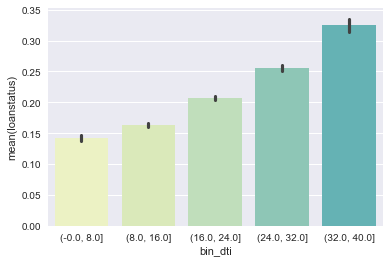

In [158]:
sns.barplot(x='bin_dti', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 10))

The figure above shows that the debt-to-income ratio is very related with the loan status. Higher dti leads to higher chance of default. 

### grade and subgrade

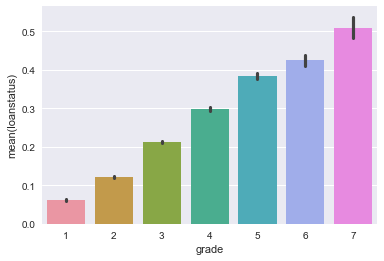

In [159]:
sns.barplot(x = 'grade', y = 'loanstatus', data = df_2014)

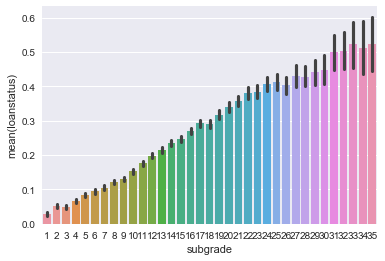

In [160]:
sns.barplot(x = 'subgrade', y = 'loanstatus', data = df_2014)

Grade and subgrade clearly show an increasing trend with default rate. They are good indicators of risk levels. 

### annualinc - Annual Income

The distribution of annual income is very skewed based on the violin plot, so the upper range of annual income is cut from 200000, with bin size of 25000. 

In [162]:
df_2014['bin_annualinc'] = pd.cut(df_2014.annualinc, bins=[0, 25000, 50000, 75000, \
                                                           100000, 125000, 150000, \
                                                           175000, 200000, max(df_2014.annualinc)], precision=0)

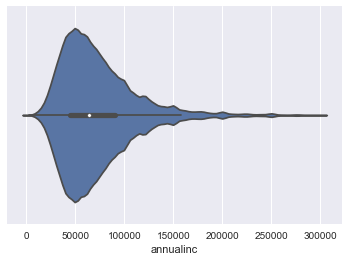

In [164]:
sns.violinplot(x='annualinc', data= df_2014[df_2014['annualinc'] <300000])

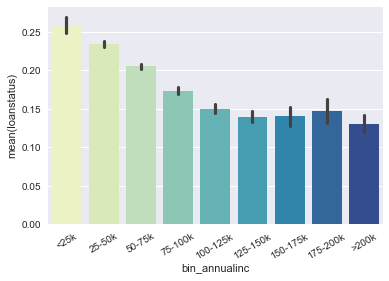

In [165]:
fig = sns.barplot(x='bin_annualinc', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 10))
fig.set_xticklabels(labels=['<25k', '25-50k', '50-75k', '75-100k', '100-125k', '125-150k',\
                            '150-175k', '175-200k', '>200k'], rotation = 30)

The fitures show that the higher annual income, the lower chance of default. 

### Intrate - Interest Rate

In [167]:
df_2014['bin_intrate'] = pd.cut(df_2014.intrate, bins=5, precision=2)

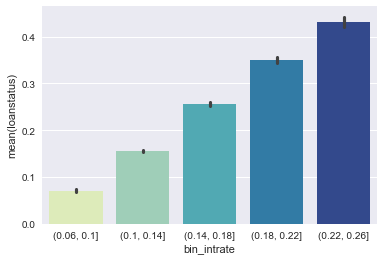

In [169]:
fig = sns.barplot(x='bin_intrate', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 5))

The Interest Rate clearly shows a positive linear relationship with default rate. 

### Installment

In [171]:
df_2014['bin_installment'] = pd.cut(df_2014.installment, bins=5, precision=2)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

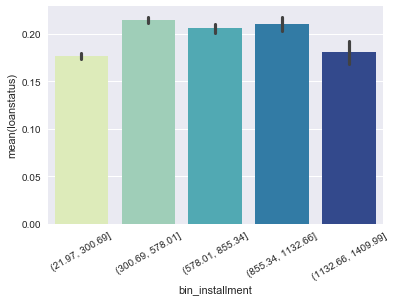

In [174]:
fig = sns.barplot(x='bin_installment', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 5))
plt.xticks(rotation = 30)

The installment amount may have a parabolic relationship with the default rate. 

### bcutil - Ration of total current loan balance to bank card credit limit (Portion of Balance)

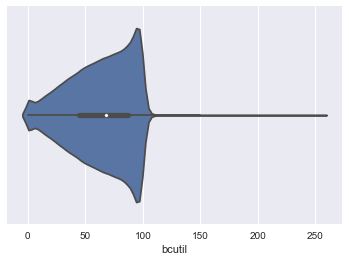

In [176]:
sns.violinplot(x='bcutil', data= df_2014)

The distribution of the Portion of Balance is also very skewed. A interesting finding from this figure is that most of the borrowers on Lending Clube have used almost > 90% of their credit limit. So Lending Club may be dealing with highly risky borrowers that may not be able to borrow from banks. There are a small amount of borrowers with loan balance > 3 times of credit limit. These may mark even higher risk of default. 

In [177]:
df_2014['bin_bcutil'] = pd.cut(df_2014.bcutil, bins=[0, 20, 40, 60, \
                                                           80, 100, 120, \
                                                           max(df_2014.bcutil)], precision=0)

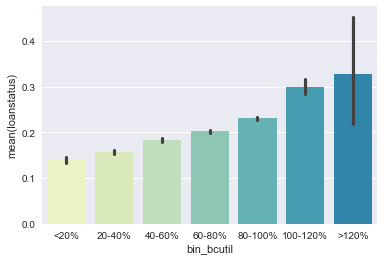

In [179]:
fig = sns.barplot(x='bin_bcutil', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 10))
fig.set_xticklabels(labels=['<20%', '20-40%', '40-60%', '60-80%', '80-100%', '100-120%', '>120%'])

It is not surprising to see an increasing trend of default rate vs. Portion of Balance. The variance of default rate also increase with higher Portion of Balance. 

### Credit History

In [181]:
df_2014['bin_credit_hist'] = pd.cut(df_2014.credit_hist, bins=5, precision=0)

In [182]:
df_2014.bin_credit_hist.value_counts()

(1863.0, 6843.0]      101324
(6843.0, 11798.0]      64785
(11798.0, 16754.0]      9635
(16754.0, 21709.0]       794
(21709.0, 26664.0]        14
Name: bin_credit_hist, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

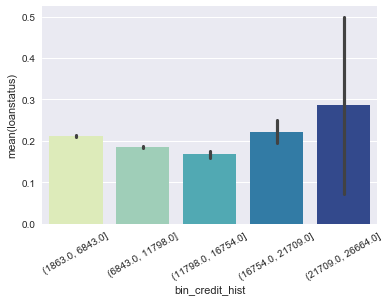

In [186]:
fig = sns.barplot(x='bin_credit_hist', y= 'loanstatus', data = df_2014, palette=sns.color_palette("YlGnBu", 5))
plt.xticks(rotation = 30)

No apparent trend is seen between credit history and default rate, although the variation seems to increase with longer credit history. 

# XGBoost Model Building

[[go back to the top]](#TABLE-OF-CONTENTS)

## Train/Test Splitting

Because this model uses historic data to predict future performances, when spliting the train/test datasets, the historic 2014 loan data are splitted into two parts chronologically: Dec/Nov/Oct data as the test set, and Jan - Sep as the train set. 

In [190]:
num_vars.remove('id')

In [191]:
train_vars = num_vars + OHE_vars

In [192]:
df_train = df_2014[train_vars + ['loanstatus']][df_2014.issued < dt.date(2014, 10, 1)]
df_test = df_2014[train_vars + ['loanstatus']][df_2014.issued >= dt.date(2014, 10, 1)]

In [194]:
df_2014.shape

(176552, 106)

## Parameter Auto-tuning

In this section both packages of XGBoost and BayesianOptimization are used. XGBoost is the model buiding algorithm. There are a number of parameters used in XGBoost, of which 5 parameters are of greater importance and given fine tuning. The parameter tuning is conducted with the Bayesian Optimization algorithm. 

Bayesian Optmization is a constrained global optimization package built upon bayesian inference and gaussian process. It attempts to find the maximum value of an unknown function based on a few starting points, in as few iterations as possible. This technique is particularly suited for optimization of high cost functions. In this case the target function is the cross-validation score from XGBoost models. The function is defined as "xgb_evaluate", where the output of this function is the best cross-validation score for each set of parameters. The cross-validation uses "auc" (area under the ROC curve) as the scoring mectrics. The early stop callback is set at 50, meaning that if no improvement of score after 50 interations, the procedure is stopped. 

The Bayesian Optimization process then maximizes the target function based on 8 initial points and interate 40 times to yield the best set of parameters leading to the highst "auc" scores. 

In [195]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn import metrics, preprocessing, cross_validation

In [196]:
x_train = df_train[train_vars]
y_train = df_train['loanstatus']
x_test = df_test[train_vars]
y_test = df_test['loanstatus']

In [197]:
dtrain = xgb.DMatrix(x_train, y_train, missing= np.nan)
dtest = xgb.DMatrix(x_test, missing= np.nan)

In [198]:
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True    


    cv_result = xgb.cv(params, dtrain,
                       num_boost_round=15000,
                       nfold=5,
                       metrics={'auc'},
                       seed=1234,
                       stratified=True,
                       callbacks=[xgb.callback.early_stop(50)])

    return cv_result['test-auc-mean'].max()

In [199]:
xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 10),
                              'min_child_weight': (0, 100),
                              'colsample_bytree': (0.5, 1),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

In [200]:
%%time
xgb_BO.maximize(init_points=8, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[79]	train-auc:0.811886+0.000808782	test-auc:0.729287+0.00273935

    1 | 01m41s |    0.72929 |             0.5225 |    0.1654 |      7.6720 |             3.2764 |      0.7968 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[144]	train-auc:0.781709+0.000471055	test-auc:0.73176+0.00225708

    2 | 03m05s |    0.73176 |             0.5852 |    1.9470 |      7.4574 |            94.6238 |      0.6007 | 
Multiple eval metrics have been passed: 'test-auc' will be used for 

C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.39115543e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   10 | 02m27s |    0.73252 |             0.5006 |    0.0040 |      4.1831 |            99.2280 |      0.9975 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[434]	train-auc:0.76173+0.000645651	test-auc:0.732524+0.00293819



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0003462]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   11 | 03m20s |    0.73252 |             0.5067 |    1.6646 |      3.0371 |            36.7151 |      0.5218 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[423]	train-auc:0.762899+0.000746077	test-auc:0.732473+0.00298235



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00012298]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


   12 | 02m55s |    0.73247 |             0.5054 |    0.6874 |      3.0100 |            24.9993 |      0.9924 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[437]	train-auc:0.763713+0.000704896	test-auc:0.732676+0.00288638

   13 | 04m37s |    0.73268 |             0.9758 |    1.9255 |      3.1392 |            55.4462 |      0.9434 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[429]	train-auc:0.758719+0.000851918	test-auc:0.732309+0.00248762



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024162]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 03m13s |    0.73231 |             0.5019 |    1.8098 |      3.0278 |            99.3550 |      0.6313 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[447]	train-auc:0.761934+0.000853866	test-auc:0.732778+0.00296676

   15 | 03m10s |    0.73278 |             0.5361 |    1.9393 |      3.1314 |            69.3074 |      0.9884 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[94]	train-auc:0.796738+0.000570413	test-auc:0.731313+0.00287163

   16 | 03m50s |    0.73131 |             0.9933 |    1.7109 |      9.0647 |            99.9134 |      0.9421 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[525]	train-auc:0.769073+0.

C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.41598318e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   20 | 02m48s |    0.73196 |             0.5671 |    0.1547 |      3.0494 |             8.8773 |      0.9781 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[371]	train-auc:0.765638+0.000536803	test-auc:0.731959+0.00310219

   21 | 04m24s |    0.73196 |             0.9550 |    0.2039 |      3.1582 |             0.4525 |      0.6124 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[462]	train-auc:0.766521+0.000737136	test-auc:0.732581+0.00308396



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.52473640e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   22 | 04m54s |    0.73258 |             0.9791 |    1.8872 |      3.9783 |            33.7991 |      0.9612 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[438]	train-auc:0.761745+0.000713643	test-auc:0.732852+0.00296446

   23 | 04m41s |    0.73285 |             0.9980 |    0.1880 |      3.0743 |            95.0166 |      0.9996 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[439]	train-auc:0.763984+0.00100382	test-auc:0.732229+0.00287895



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00066232]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   24 | 04m34s |    0.73223 |             0.9374 |    1.9003 |      3.5453 |            45.1773 |      0.9754 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[448]	train-auc:0.762223+0.000594522	test-auc:0.733219+0.00320019

   25 | 03m12s |    0.73322 |             0.5123 |    0.0939 |      3.1282 |            62.1037 |      0.9263 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[222]	train-auc:0.777919+0.00112029	test-auc:0.732887+0.00296713

   26 | 02m37s |    0.73289 |             0.5290 |    0.0299 |      5.3878 |            79.4190 |      0.9796 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[198]	train-auc:0.792187+0.

C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00049019]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   27 | 04m24s |    0.73116 |             0.9976 |    1.9406 |      6.1318 |            86.9074 |      0.9836 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[80]	train-auc:0.831629+0.000746133	test-auc:0.729759+0.00301402

   28 | 02m16s |    0.72976 |             0.5380 |    0.1207 |      9.8727 |            27.5043 |      0.8982 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[93]	train-auc:0.80489+0.00110124	test-auc:0.730686+0.00224271



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  5.89946285e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   29 | 02m21s |    0.73069 |             0.5099 |    0.2265 |      9.7184 |            68.7047 |      0.9220 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[481]	train-auc:0.763321+0.000645446	test-auc:0.733133+0.00283533

   30 | 03m26s |    0.73313 |             0.5195 |    0.0466 |      3.0092 |            75.1464 |      0.9224 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[462]	train-auc:0.760769+0.000621117	test-auc:0.73307+0.00249348

   31 | 03m30s |    0.73307 |             0.5122 |    0.0822 |      3.1249 |            89.9486 |      0.6657 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[359]	train-auc:0.758557+0.

C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00060462]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00355656]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   32 | 04m20s |    0.73283 |             0.9730 |    0.0437 |      3.0221 |            64.7606 |      0.6085 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[188]	train-auc:0.767305+0.000594382	test-auc:0.731507+0.00224274

   33 | 02m33s |    0.73151 |             0.5243 |    1.8379 |      5.3817 |            76.9180 |      0.5252 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[448]	train-auc:0.765878+0.000531705	test-auc:0.731935+0.00293552



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.37121712e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   34 | 03m22s |    0.73194 |             0.5565 |    1.9693 |      3.0534 |            16.5248 |      0.9725 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[370]	train-auc:0.762233+0.000695649	test-auc:0.731985+0.00255818

   35 | 03m06s |    0.73199 |             0.5332 |    1.6861 |      3.0263 |             3.9102 |      0.5257 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[528]	train-auc:0.764225+0.000704813	test-auc:0.733073+0.00323163

   36 | 03m38s |    0.73307 |             0.5098 |    1.3093 |      3.1736 |            93.0095 |      0.9980 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[92]	train-auc:0.774532+0.

C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01020962]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   42 | 02m52s |    0.73137 |             0.5307 |    0.0388 |      9.8081 |            93.5311 |      0.9723 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[304]	train-auc:0.757146+0.000563681	test-auc:0.732093+0.00288155



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00012107]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   43 | 03m53s |    0.73209 |             0.9738 |    1.9732 |      3.0307 |            23.3761 |      0.5230 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[296]	train-auc:0.753149+0.000533646	test-auc:0.732763+0.00290654



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00082022]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00937212]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   44 | 02m46s |    0.73276 |             0.5850 |    1.8790 |      3.1292 |            59.2059 |      0.5049 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[66]	train-auc:0.900004+0.00148187	test-auc:0.724378+0.00237957



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00524904]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   45 | 03m31s |    0.72438 |             0.9266 |    1.8986 |      9.8413 |             0.0869 |      0.7534 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[121]	train-auc:0.789505+0.0012401	test-auc:0.731256+0.00304609

   46 | 02m26s |    0.73126 |             0.5064 |    0.0905 |      6.2663 |            19.1586 |      0.9127 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[120]	train-auc:0.805623+0.00149513	test-auc:0.730147+0.0025048



C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00035053]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00085365]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00021704]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\python\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wit

   47 | 04m02s |    0.73015 |             0.9926 |    0.1643 |      8.7643 |            74.7417 |      0.9834 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
Stopping. Best iteration:
[376]	train-auc:0.763947+0.000478171	test-auc:0.731917+0.0026754

   48 | 04m04s |    0.73192 |             0.9764 |    1.7190 |      3.1761 |             3.0137 |      0.9964 | 
Wall time: 2h 44min 23s


In [201]:
BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
BO_scores = BO_scores.sort_values(by='score',ascending=False).reset_index()
BO_scores.head()

,index,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
0,16,0.512271,0.093932,3.128158,62.103749,0.926263,0.733219
1,21,0.519508,0.046611,3.009198,75.146367,0.922384,0.733133
2,27,0.509843,1.309254,3.173647,93.009456,0.998017,0.733073
3,22,0.512193,0.082187,3.124860,89.948624,0.665704,0.733070
4,29,0.595658,0.056093,3.108773,53.271249,0.960228,0.732956


## Find Best Parameters

The resulted parameters are sorted in a descending order of their corresponding scores. The best parameters yield an AUC score of 0.733219. The best parameters are then input to the cross-validation function to find the best interation.

* 'max_depth': 3, 
* 'min_child_weight': 62, 
* 'colsample_bytree': 0.5123, 
* 'subsample': 0.9262, 
* 'gamma': 0.093932, 
* 'objective': 'binary:logistic', 
* 'eta': 0.02, 
* 'seed': 1234

In [209]:
best_params = dict()

best_params['max_depth'] = int(BO_scores['max_depth'][0])
best_params['min_child_weight'] = int(BO_scores['min_child_weight'][0])
best_params['colsample_bytree'] = BO_scores['colsample_bytree'][0]
best_params['subsample'] = BO_scores['subsample'][0]
best_params['gamma'] = BO_scores['gamma'][0]

best_params['objective'] = 'binary:logistic'
best_params['eta'] = 0.02
best_params['seed'] = 1234

In [210]:
cv_result = xgb.cv(best_params, dtrain,
                   num_boost_round=15000,
                   nfold=5,
                   metrics={'auc'},
                   seed=1234,
                   stratified=True,
                   callbacks=[xgb.callback.early_stop(200)],
                   verbose_eval=50)


best_iteration = len(cv_result)
best_score = cv_result['test-auc-mean'].max()
print("Best score %f, best iteration %d" % (best_score,best_iteration) )

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 200 rounds.
[0]	train-auc:0.682243+0.0108175	test-auc:0.679998+0.0119664
[50]	train-auc:0.713297+0.000297819	test-auc:0.711012+0.0015505
[100]	train-auc:0.716541+0.000283336	test-auc:0.713916+0.00130518
[150]	train-auc:0.72062+0.000363427	test-auc:0.717262+0.00137011
[200]	train-auc:0.724822+0.000434748	test-auc:0.720502+0.00156927
[250]	train-auc:0.728324+0.000497568	test-auc:0.723073+0.00177707
[300]	train-auc:0.731077+0.000584943	test-auc:0.724928+0.00184167
[350]	train-auc:0.733209+0.000604974	test-auc:0.726233+0.0020002
[400]	train-auc:0.734992+0.000645641	test-auc:0.727226+0.0021023
[450]	train-auc:0.736503+0.000662254	test-auc:0.72792+0.00219674
[500]	train-auc:0.737829+0.000632363	test-auc:0.728534+0.00221304
[550]	train-auc:0.739036+0.000639398	test-auc:0.72903+0.00225299
[600]	train-auc:0.740112+0.000634181	test-auc:0.729458+0.00230512
[650]	train-

Through cross-validation, the best iteration is found to be 2443, and the corresponding best AUC score is 0.7338. The XGBoost model is then trained on the training set, based on the best parameters and iteration.  

In [213]:
gbm = xgb.train(best_params, dtrain, num_boost_round=best_iteration)

# Model Integration

[[go back to the top]](#TABLE-OF-CONTENTS)

## Pickle Model (gbm) and Feature. 

The trained XGBoost model object "gbm" here is saved into a pickle file named "model.pkl". A input file containing an example dataset is saved into a pickle file named "feature.pkl". Both model.pkl and feature.pkl are saved into a web-application framework build with Flask. Running the Flask framework results in a web application interface which allow users to adjust important parameters of a loan and get a predicted default rate. As pictured below. 
![Fintech Web Application Interface](Fintech.png)

In [214]:
import pickle

In [215]:
with open('model.pkl', 'wb') as outfile:
    pickle.dump(gbm, outfile)

The example dataset in the feature.pkl file uses the average of x_test as the default values for all features. 

In [217]:
feature = pd.DataFrame(index = [0],columns= x_test.columns)

In [218]:
for i in x_test[num_vars].columns:
    if x_test.loc[:, i].dtypes == 'float64':
        feature[i] = round(x_test.loc[:, i].mean(), 2)
    else:
        feature[i] = int(round(x_test.loc[:, i].mean()))

In [219]:
feature[OHE_vars] = 0
feature[OHE_vars] = feature[OHE_vars].astype('int')

In [220]:
feature['home_mort'] = 1
feature['pur_debt_consolidation'] = 1
feature['isincv_nv'] = 1

In [221]:
with open('feature.pkl', 'wb') as outfile:
    pickle.dump(feature, outfile)

# Model Evaluation

[[go back to the top]](#TABLE-OF-CONTENTS)

## Feature Importance

The importance of features is generated based on the feature importance scores from the XGBoost model. From the table and plot below it is found that the top 10 important features include Annual Income, Debt to Income Ratio, Interest Rate, Portion of Balance, and so on. Generally the important features match the trend observed in the [Feature Responses Visualization](#Feature-Responses-Visualization).   

In [222]:
importance = gbm.get_fscore()
df_importance = pd.DataFrame(list(importance.items()), columns = ['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore']/df_importance['fscore'].sum()
df_importance.sort_values(['fscore'], ascending= False, inplace= True)

In [225]:
df_importance.head(10)

,feature,fscore
7,annualinc,0.042099
3,dti,0.039607
24,addrzip,0.037653
1,intrate,0.036508
9,loanamount,0.031254
11,installment,0.029503
18,mosinoldrevtlop,0.027684
25,revolbal,0.025057
4,avgcurbal,0.024923
30,credit_hist,0.023980


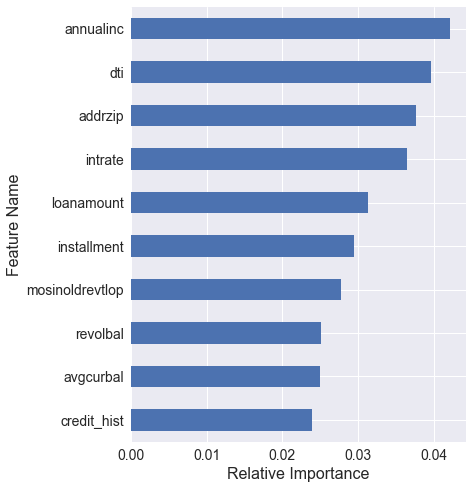

In [226]:
df_importance[:10].sort_values(by='fscore').plot(kind = 'barh', x = 'feature', y = 'fscore', legend= False, figsize=(6,8) )
plt.xlabel('Relative Importance', fontsize = 16)
plt.ylabel('Feature Name', fontsize = 16)
plt.tick_params(labelsize = 14)

## Testing Set Scores

The trained model is then used to predict the default rates in the testing dateset. The predicted default rate on the test set is about 0.2055, very close to the average default rate of around 0.20. The result of model performance is visualized via the ROC curve. The AUC scores on the training and validation sets are about 0.76, and the AUC score on the testing set is about 0.72. 

In [227]:
y_pred = gbm.predict(dtest)

In [229]:
y_pred.mean(), y_pred.max(), y_pred.min()

(0.20550095, 0.87483752, 0.0055377535)

In [230]:
df_2014.loanstatus.mean()

0.1990744936336037

#### Train/Test Split in x_train

In [231]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

In [232]:
x_t, x_cv, y_t, y_cv = train_test_split(x_train, y_train, test_size = 0.3, \
                                    random_state = 1234, stratify = y_train)

## Plot ROC-AUC

In [233]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets

In [234]:
type(y_t)

pandas.core.series.Series

In [235]:
def draw_ROC (model, traindata, cvdata, testdata, trainy, cvy, testy):
    prob_0 = model.predict(traindata)
    prob_1 = model.predict(cvdata)
    prob_2 = model.predict(testdata)
    fpr_0, tpr_0, thresholds_0 = roc_curve(trainy, prob_0)
    fpr_1, tpr_1, thresholds_1 = roc_curve(cvy, prob_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(testy, prob_2)
    roc_auc_0 = auc(fpr_0, tpr_0)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    print ("Area under the ROC Curve - Train: %f" %(roc_auc_0))
    print ("Area under the ROC Curve - Validation: %f" % (roc_auc_1))
    print ("Area under the ROC Curve - Test: %f" % (roc_auc_2))
    
    Youdens_0 = tpr_0 - fpr_0
    Youdens_1 = tpr_1 - fpr_1
    Youdens_2 = tpr_2 - fpr_2
    
    #Plot ROC Curve
    plt.figure(figsize = (8,8))
    plt.plot(fpr_0, tpr_0, label = 'ROC Curve - Train (AUC = %0.2f)' % (roc_auc_0), color= 'r')
    plt.plot(fpr_1, tpr_1, label = 'ROC Curve - Validation (AUC = %0.2f)' % (roc_auc_1), color= 'b')
    plt.plot(fpr_2, tpr_2, label = 'ROC Curve - Test (AUC = %0.2f)' % (roc_auc_2), color= 'g')
    plt.plot([0,1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc='lower right')
    plt.show()
    
    return (Youdens_0, thresholds_0, Youdens_1, thresholds_1, Youdens_2, thresholds_2)

In [236]:
x_t_xgb = xgb.DMatrix(x_t, missing= np.nan)
x_cv_xgb = xgb.DMatrix(x_cv, missing= np.nan)

Area under the ROC Curve - Train: 0.760763
Area under the ROC Curve - Validation: 0.758659
Area under the ROC Curve - Test: 0.719680


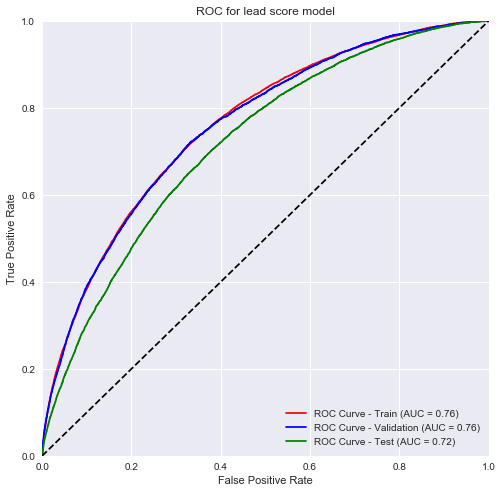

In [237]:
Youdens_0, thresholds_0, Youdens_1, thresholds_1, Youdens_2, thresholds_2 = \
draw_ROC(gbm, x_t_xgb, x_cv_xgb, dtest, y_t, y_cv, y_test)

## Select Thresholds

The best threshold of predicting default is determined based on Youden's Index. The Youden's Index optimizes the sensitivity and specificity. From the figure below, Youden's Index maximizes at a threshold of 0.18. The maximum f1-score at the threshold of 0.18 is 0.48721, with a recall rate of 0.71, suggesting that the model has 71% chance in correctly identifying the default loans. 

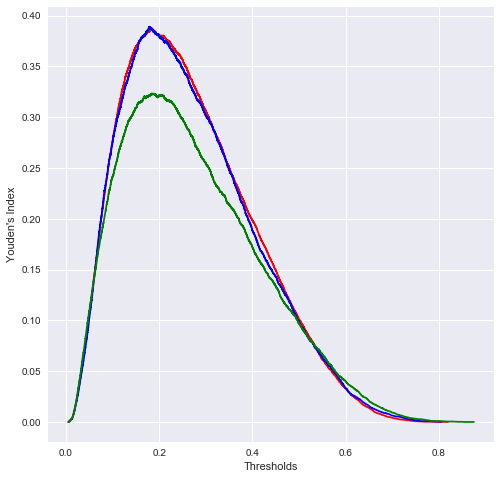

In [238]:
plt.figure(figsize = (8,8))
plt.plot(thresholds_0, Youdens_0, label = "Youden's Index - Train", color= 'r')
plt.plot(thresholds_1, Youdens_1, label = "Youden's Index - Validation", color= 'b')
plt.plot(thresholds_2, Youdens_2, label = "Youden's Index - Test", color= 'g')
plt.xlabel('Thresholds')
plt.ylabel("Youden's Index")

In [239]:
best_threshold = 0.2

In [240]:
from sklearn.metrics import precision_recall_fscore_support

In [243]:
for thrd in [0, 0.1, 0.15, 0.18, 0.2, 0.22, 0.4]:
    test_results = []
    for prob in y_pred:
        if prob > thrd:
            test_results.append(1)
        else:
            test_results.append(0)
    print ("threshold:", thrd, precision_recall_fscore_support(y_test, test_results, pos_label=1, average='binary'))

threshold: 0 (0.24376501016072419, 1.0, 0.39197920534719644, None)
threshold: 0.1 (0.30579868708971553, 0.90024630541871919, 0.45652382782475021, None)
threshold: 0.15 (0.34618420506003073, 0.78940886699507384, 0.48130071909203798, None)
threshold: 0.18 (0.36983947768887143, 0.71371731716559306, 0.48721182138584412, None)
threshold: 0.2 (0.38519745926539628, 0.6606669192876089, 0.48665433864833735, None)
threshold: 0.22 (0.40070833851124643, 0.61093217127699884, 0.48397748592870543, None)
threshold: 0.4 (0.51305713724720203, 0.24753694581280788, 0.33395105118537927, None)


# CONCLUSION

[[go back to the top]](#TABLE-OF-CONTENTS)

This FinTech project built a program that serves as an intelligent investment consultant, which in estabishes a predictive model to evaluate the outcome of loan default rate in real-time, and feedback the prediction results to users via an interactive web-application portal. The model is built upon the historic loan data of year 2014 from the Lending Club's open resource. After data cleaning and feature engineering, model is built based on XGBoost algorithm with AUC score as model metrics. Bayesian Optimization is used to maximize the AUC score and find out the best parameters for the XGBoost model. Finally, a well-tuned predictive model is established with a AUC score of 0.73 on test sets. Feature importance plot shows several key features in predicting the default rate, such as Debt-to-Income Ratio, Annual Income, Portion of Balance, Interest Rate, and so on. 